# Setup

In [12]:
%load_ext autoreload
%autoreload 2
%aimport

%matplotlib inline 

import torch
import matplotlib.pyplot as plt
from einops import rearrange

from bliss.catalog import TileCatalog, get_images_in_tiles
from bliss.models.galsim_decoder import PsfSampler
from bliss.encoder import Encoder


device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:

5


In [13]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate

with initialize(config_path="../../sdss_galaxies/config"):
    cfg = compose("config", overrides=[])

## Load model

In [8]:
location = instantiate(cfg.models.detection_encoder).to(device).eval()
location.load_state_dict(
    torch.load(cfg.plots.location_checkpoint, map_location=location.device)
)

<All keys matched successfully>

In [53]:
encoder = Encoder(location.eval(), n_images_per_batch=10, n_rows_per_batch=15).to(device)

## Load dataset

In [34]:
with initialize(config_path="../config"):
    cfg = compose("config", overrides=[])

In [35]:
ds = instantiate(cfg.datasets.galsim_blended_std_psf, batch_size=512, n_batches=20, num_workers=20)

Generating dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:41<00:00,  2.05s/it]


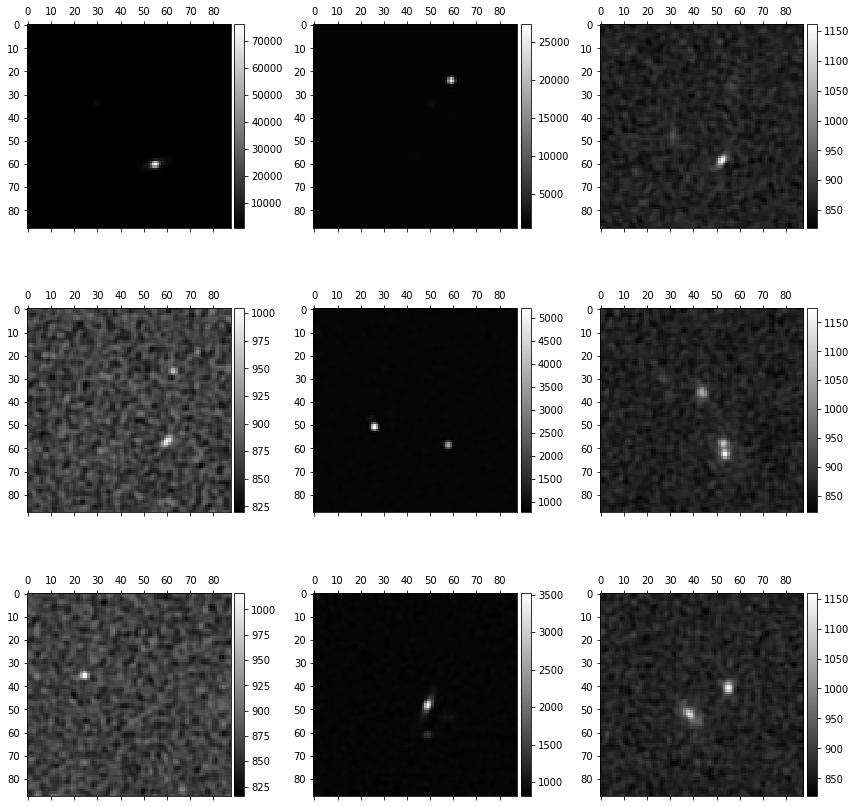

In [38]:
from bliss.generate import generate
generate(ds, '../output/homo_dataset.pt', '../output/homo_images.png', 9, global_params=("background",))

# Run model on saved dataset

In [54]:
sds = torch.load('../output/homo_dataset.pt')
sds['background'].shape

torch.Size([1, 88, 88])

In [55]:
n_batches = sds['images'].shape[0]
slen = sds['images'].shape[-1]
background = rearrange(sds['background'], '1 h w -> 1 1 h w')
background = background.expand(n_batches, 1, slen, slen)
tile_est = encoder.variational_mode(sds['images'], background)


Encoding ptiles: 1024it [00:47, 21.36it/s]


# Metrics on prediction compared to truth

In [59]:
est = tile_est.cpu().to_full_params() # full estimated catalog

In [66]:
catalog_dict = {
    "locs": batch["locs"][:, :, :, 0 : self.max_detections],
    "log_fluxes": batch["log_fluxes"][:, :, :, 0 : self.max_detections],
    "galaxy_bools": batch["galaxy_bools"][:, :, :, 0 : self.max_detections],
    "n_sources": batch["n_sources"].clamp(max=self.max_detections),
}
true_tile_catalog = TileCatalog(self.tile_slen, catalog_dict)
true_full_catalog = true_tile_catalog.to_full_params()

torch.Size([10240, 9, 2])